# Evaluate bootstrapped model results

## Imports and constants

In [1]:
# builtins
import pathlib

# externals
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

# locals
from climax.main.io import OBS_PATH, ERA5_PATH
from climax.main.config import VALID_PERIOD
from pysegcnn.core.utils import search_files

In [2]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'pr': 'precipitation'}

In [3]:
# path to bootstrapped model results
RESULTS = pathlib.Path('/mnt/CEPH_PROJECTS/FACT_CLIMAX/ERA5_PRED/bootstrap')

## Search model configurations

In [4]:
# predictand to evaluate
PREDICTAND = 'tasmin'

In [5]:
# loss function and optimizer
LOSS = ['L1Loss', 'MSELoss', 'BernoulliGammaLoss'] if PREDICTAND == 'pr' else ['L1Loss', 'MSELoss']
OPTIM = 'Adam'

In [6]:
# model to evaluate
models = ['USegNet_{}_ztuvq_500_850_p_dem_doy_1mm_{}_{}'.format(PREDICTAND, loss, OPTIM) if loss == 'BernoulliGammaLoss' else
          'USegNet_{}_ztuvq_500_850_p_dem_doy_{}_{}'.format(PREDICTAND, loss, OPTIM) for loss in LOSS]

In [7]:
# get bootstrapped models
models = {loss: sorted(search_files(RESULTS.joinpath(PREDICTAND), model + '(.*).nc$'),
                       key=lambda x: int(x.stem.split('_')[-1])) for loss, model in zip(LOSS, models)}
models

{'L1Loss': [PosixPath('/mnt/CEPH_PROJECTS/FACT_CLIMAX/ERA5_PRED/bootstrap/tasmin/USegNet_tasmin_ztuvq_500_850_p_dem_doy_L1Loss_Adam_d1e-03_lr3e-04/USegNet_tasmin_ztuvq_500_850_p_dem_doy_L1Loss_Adam_d1e-03_lr3e-04_01.nc'),
  PosixPath('/mnt/CEPH_PROJECTS/FACT_CLIMAX/ERA5_PRED/bootstrap/tasmin/USegNet_tasmin_ztuvq_500_850_p_dem_doy_L1Loss_Adam_d1e-03_lr3e-04/USegNet_tasmin_ztuvq_500_850_p_dem_doy_L1Loss_Adam_d1e-03_lr3e-04_02.nc'),
  PosixPath('/mnt/CEPH_PROJECTS/FACT_CLIMAX/ERA5_PRED/bootstrap/tasmin/USegNet_tasmin_ztuvq_500_850_p_dem_doy_L1Loss_Adam_d1e-03_lr3e-04/USegNet_tasmin_ztuvq_500_850_p_dem_doy_L1Loss_Adam_d1e-03_lr3e-04_03.nc'),
  PosixPath('/mnt/CEPH_PROJECTS/FACT_CLIMAX/ERA5_PRED/bootstrap/tasmin/USegNet_tasmin_ztuvq_500_850_p_dem_doy_L1Loss_Adam_d1e-03_lr3e-04/USegNet_tasmin_ztuvq_500_850_p_dem_doy_L1Loss_Adam_d1e-03_lr3e-04_04.nc'),
  PosixPath('/mnt/CEPH_PROJECTS/FACT_CLIMAX/ERA5_PRED/bootstrap/tasmin/USegNet_tasmin_ztuvq_500_850_p_dem_doy_L1Loss_Adam_d1e-03_lr3e-04/USegN

## Load datasets

### Load observations

In [8]:
# load observations
y_true = xr.open_dataset(OBS_PATH.joinpath(PREDICTAND, 'OBS_{}_1980_2018.nc'.format(PREDICTAND)),
                         chunks={'time': 365})
y_true = y_true.sel(time=VALID_PERIOD)  # subset to time period covered by predictions
y_true = y_true.rename({NAMES[PREDICTAND]: PREDICTAND}) if PREDICTAND == 'pr' else y_true

In [9]:
# mask of missing values
missing = np.isnan(y_true[PREDICTAND])

### Load reference data

In [10]:
# ERA-5 reference dataset
if PREDICTAND == 'pr':
    y_refe = xr.open_dataset(search_files(ERA5_PATH.joinpath('ERA5', 'total_precipitation'), '.nc$').pop(),
                             chunks={'time': 365})
    y_refe = y_refe.rename({'tp': 'pr'})
else:
    y_refe = xr.open_dataset(search_files(ERA5_PATH.joinpath('ERA5', '2m_{}_temperature'.format(PREDICTAND.lstrip('tas'))), '.nc$').pop(),
                             chunks={'time': 365})
    y_refe = y_refe - 273.15  # convert to °C
    y_refe = y_refe.rename({'t2m': PREDICTAND})

In [11]:
# subset to time period covered by predictions
y_refe = y_refe.sel(time=VALID_PERIOD).drop_vars('lambert_azimuthal_equal_area')
y_refe = y_refe.transpose('time', 'y', 'x')  # change order of dimensions

### Load QM-adjusted reference data

In [12]:
y_refe_qm = xr.open_dataset(ERA5_PATH.joinpath('QM_ERA5_{}_day_19912010.nc'.format(PREDICTAND)), chunks={'time': 365})
y_refe_qm = y_refe_qm.transpose('time', 'y', 'x')  # change order of dimensions

In [13]:
# center hours at 00:00:00 rather than 12:00:00
y_refe_qm['time'] = np.asarray([t.astype('datetime64[D]') for t in y_refe_qm.time.values])

In [14]:
# subset to time period covered by predictions
y_refe_qm = y_refe_qm.sel(time=VALID_PERIOD).drop_vars('lambert_azimuthal_equal_area')

In [15]:
# align datasets and mask missing values
y_true, y_refe, y_refe_qm = xr.align(y_true[PREDICTAND], y_refe[PREDICTAND], y_refe_qm[PREDICTAND], join='override')
y_refe = y_refe.where(~missing, other=np.nan)
y_refe_qm = y_refe_qm.where(~missing, other=np.nan)

### Load model predictions

In [16]:
y_pred_raw = {k: [xr.open_dataset(v, chunks={'time': 365}) for v in models[k]] for k in models.keys()}
if PREDICTAND == 'pr':
    y_pred_raw = {k: [v.rename({NAMES[PREDICTAND]: PREDICTAND}) if k == 'BernoulliGammaLoss' else v.rename({PREDICTAND: PREDICTAND}) for v in y_pred_raw[k]] for k in y_pred_raw.keys()}
    y_pred_raw = {k: [v.transpose('time', 'y', 'x') for v in y_pred_raw[k]] for k in y_pred_raw.keys()}

In [17]:
# align datasets and mask missing values
y_prob = {}
y_pred = {}
for loss, sim in y_pred_raw.items():
    y_pred[loss], y_prob[loss] = [], []
    for y_p in sim:
        # check whether evaluating precipitation or temperatures
        if len(y_p.data_vars) > 1:
            _, _, y_p, y_p_prob = xr.align(y_true, y_refe, y_p[PREDICTAND], y_p.prob, join='override')
            y_p_prob = y_p_prob.where(~missing, other=np.nan)  # mask missing values
            y_prob[loss].append(y_p_prob)
        else:
            _, _, y_p = xr.align(y_true, y_refe, y_p[PREDICTAND], join='override')

        # mask missing values
        y_p = y_p.where(~missing, other=np.nan)
        y_pred[loss].append(y_p)

## Ensemble predictions

In [18]:
# create ensemble dataset
ensemble = {k: xr.Dataset({'Member-{}'.format(i): member for i, member in enumerate(y_pred[k])}).to_array('members')
            for k in y_pred.keys() if y_pred[k]}

In [19]:
# full ensemble mean prediction and standard deviation
ensemble_mean_full = {k: v.mean(dim='members') for k, v in ensemble.items()}
ensemble_std_full = {k: v.std(dim='members') for k, v in ensemble.items()}

In [20]:
# ensemble mean prediction using three random members
ensemble_3 = np.random.randint(0, len(ensemble['L1Loss'].members), size=3)
ensemble_mean_3 = {k: v[ensemble_3, ...].mean(dim='members') for k, v in ensemble.items()}
ensemble_std_3 = {k: v[ensemble_3, ...].std(dim='members') for k, v in ensemble.items()}

In [21]:
# ensemble mean prediction using five random members
ensemble_5 = np.random.randint(0, len(ensemble['L1Loss'].members), size=5)
ensemble_mean_5 = {k: v[ensemble_5, ...].mean(dim='members') for k, v in ensemble.items()}
ensemble_std_5 = {k: v[ensemble_5, ...].std(dim='members') for k, v in ensemble.items()}

# Model validation

In [22]:
# TODO: coefficient of determination, AUC/ROCSS for pr

## Bias, MAE, and RMSE for reference data

Calculate yearly average bias, MAE, and RMSE over entire reference period for model predictions, ERA-5, and QM-adjusted ERA-5.

In [23]:
# yearly average values over validation period
y_refe_yearly_avg = y_refe.groupby('time.year').mean(dim='time')
y_refe_qm_yearly_avg = y_refe_qm.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')

In [24]:
# yearly average bias, mae, and rmse for ERA-5
bias_refe = ((y_refe_yearly_avg - y_true_yearly_avg) / y_true_yearly_avg) * 100 if PREDICTAND == 'pr' else y_refe_yearly_avg - y_true_yearly_avg
mae_refe = np.abs(y_refe_yearly_avg - y_true_yearly_avg)
rmse_refe = (y_refe_yearly_avg - y_true_yearly_avg) ** 2

In [25]:
# yearly average bias, mae, and rmse for QM-Adjusted ERA-5
bias_refe_qm = ((y_refe_qm_yearly_avg - y_true_yearly_avg) / y_true_yearly_avg) * 100 if PREDICTAND == 'pr' else y_refe_qm_yearly_avg - y_true_yearly_avg
mae_refe_qm = np.abs(y_refe_qm_yearly_avg - y_true_yearly_avg)
rmse_refe_qm = (y_refe_qm_yearly_avg - y_true_yearly_avg) ** 2

In [26]:
# compute validation metrics for reference datasets
filename = RESULTS.joinpath(PREDICTAND, 'reference.csv')
if filename.exists():
    # check if validation metrics for reference already exist
    df_ref = pd.read_csv(filename)
else:
    # compute validation metrics
    df_ref = pd.DataFrame([], columns=['bias', 'mae', 'rmse', 'product'])
    for product, metrics in zip(['Era-5', 'Era-5 QM'], [[bias_refe, mae_refe, rmse_refe], [bias_refe_qm, mae_refe_qm, rmse_refe_qm]]):
        values = pd.DataFrame([[np.sqrt(m.mean().values.item()) if name == 'rmse' else m.mean().values.item() for
                                name, m in zip(['bias', 'mae', 'rmse'], metrics)] + [product]], columns=df_ref.columns)
        df_ref = df_ref.append(values, ignore_index=True)
    
    # save metrics to disk
    df_ref.to_csv(filename, index=False)

## Bias, MAE, and RMSE for model predictions

Calculate yearly average bias, MAE, and RMSE over entire reference period for model predictions.

In [27]:
# yearly average bias, mae, and rmse for each ensemble member
y_pred_yearly_avg = {k: v.groupby('time.year').mean(dim='time') for k, v in ensemble.items()}
bias_pred = {k: ((v - y_true_yearly_avg) / y_true_yearly_avg) * 100 if PREDICTAND == 'pr'
             else v - y_true_yearly_avg for k, v in y_pred_yearly_avg.items()}
mae_pred = {k: np.abs(v - y_true_yearly_avg) for k, v in y_pred_yearly_avg.items()}
rmse_pred = {k: (v - y_true_yearly_avg) ** 2 for k, v in y_pred_yearly_avg.items()}

In [28]:
# compute validation metrics for model predictions
filename = RESULTS.joinpath(PREDICTAND, 'prediction.csv')
if filename.exists():
    # check if validation metrics for predictions already exist
    df_pred = pd.read_csv(filename)
else:
    # validation metrics for each ensemble member
    df_pred = pd.DataFrame([], columns=['bias', 'mae', 'rmse', 'product', 'loss'])
    for k in y_pred_yearly_avg.keys():
        for i in range(len(bias_pred[k])):
            values = pd.DataFrame([[np.sqrt(m.mean().values.item()) if name == 'rmse' else m.mean().values.item()
                                    for name, m in zip(['bias', 'mae', 'rmse'], [bias_pred[k][i], mae_pred[k][i], rmse_pred[k][i]])] +
                                   [bias_pred[k][i].members.item()] + [k]],
                                  columns=df_pred.columns)
            df_pred = df_pred.append(values, ignore_index=True)
        
    # validation metrics for ensembles
    for name, ens in zip(['Ensemble-3', 'Ensemble-5', 'Ensemble-{:d}'.format(len(ensemble['L1Loss']))],
                         [ensemble_mean_3, ensemble_mean_5, ensemble_mean_full]):
        for k, v in ens.items():
            yearly_avg = v.groupby('time.year').mean(dim='time')
            bias = ((((yearly_avg - y_true_yearly_avg) / y_true_yearly_avg) * 100).mean().values.item() if PREDICTAND == 'pr' else 
                    (yearly_avg - y_true_yearly_avg).mean().values.item())
            mae = np.abs(yearly_avg - y_true_yearly_avg).mean().values.item()
            rmse = np.sqrt(((yearly_avg - y_true_yearly_avg) ** 2).mean().values.item())
            values = pd.DataFrame([[bias, mae, rmse, name, k]], columns=df_pred.columns)
            df_pred = df_pred.append(values, ignore_index=True)
    
    # save metrics to disk
    df_pred.to_csv(filename, index=False)

## Plot results

In [29]:
# create a sequential colormap: for reference data, single ensemble members, and ensemble mean predictions
# palette = sns.color_palette('YlOrRd_r', 10) + sns.color_palette('Greens', 3)
palette = sns.color_palette('Blues', len(LOSS))

### Absolute values: single members vs. ensemble

In [30]:
# dataframe of single members and ensembles only
members = df_pred[~np.isin(df_pred['product'], ['Ensemble-{}'.format(i) for i in [3, 5, 10]])]
ensemble = df_pred[~np.isin(df_pred['product'], ['Member-{}'.format(i) for i in range(10)])]

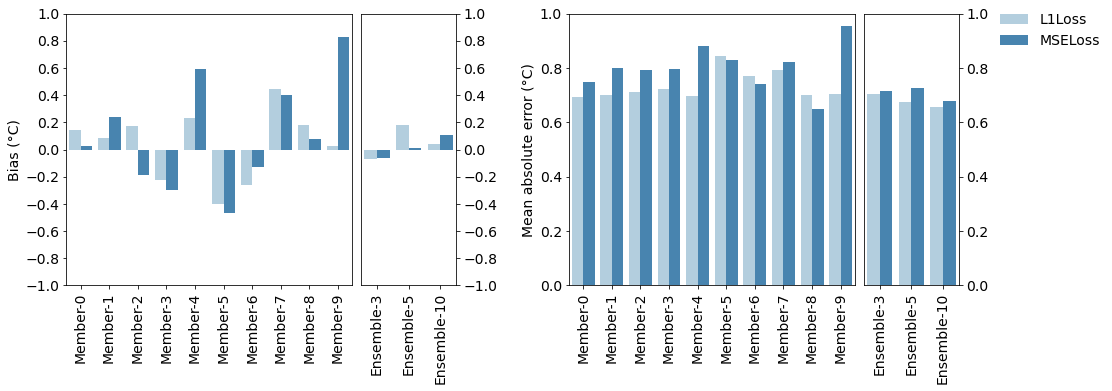

In [31]:
# initialize figure
fig = plt.figure(figsize=(16, 5))

# create grid for different subplots
grid = gridspec.GridSpec(ncols=5, nrows=1, width_ratios=[3, 1, 1, 3, 1], wspace=0.05, hspace=0)

# add subplots
ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1], sharey=ax1)
ax3 = fig.add_subplot(grid[3])
ax4 = fig.add_subplot(grid[4], sharey=ax3)
axes = [ax1, ax2, ax3, ax4]

# plot bias: single members vs. ensemble
sns.barplot(x='product', y='bias', hue='loss', data=members, palette=palette, ax=ax1);
sns.barplot(x='product', y='bias', hue='loss', data=ensemble, palette=palette, ax=ax2);

# plot mae: single members vs. ensemble
sns.barplot(x='product', y='mae', hue='loss', data=members, palette=palette, ax=ax3);
sns.barplot(x='product', y='mae', hue='loss', data=ensemble, palette=palette, ax=ax4);

# axes limits and ticks
y_lim_bias = (-50, 50) if PREDICTAND == 'pr' else (-1, 1)
y_lim_mae = (0, 2) if PREDICTAND == 'pr' else (0, 1)
y_ticks_bias = (np.arange(y_lim_bias[0], y_lim_bias[1] + 10, 10) if PREDICTAND == 'pr' else
                np.arange(y_lim_bias[0], y_lim_bias[1] + 0.2, 0.2))
y_ticks_mae = np.arange(y_lim_mae[0], y_lim_mae[1] + 0.2, 0.2)

# axis for bias
ax1.set_ylabel('Bias (%)' if PREDICTAND == 'pr' else 'Bias (°C)')
ax1.set_ylim(y_lim_bias)
ax1.set_yticks(y_ticks_bias)

# axis for mae
ax3.set_ylabel('Mean absolute error (mm)' if PREDICTAND == 'pr' else 'Mean absolute error (°C)')
ax3.set_ylim(y_lim_mae)
ax3.set_yticks(y_ticks_mae)

# adjust axis for ensemble predictions
for ax in [ax2, ax4]:
    ax.yaxis.tick_right()
    ax.set_ylabel('')

# axis fontsize and legend
for ax in axes:
    ax.tick_params('both', labelsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.yaxis.label.set_size(14)
    ax.set_xlabel('')
    
    # adjust legend
    h, _ = ax.get_legend_handles_labels()
    ax.get_legend().remove()

# show single legend
ax4.legend(bbox_to_anchor=(1.3, 1.05), loc=2, frameon=False, fontsize=14);

# save figure
fig.savefig('./Figures/bootstrap/{}_members_vs_ensemble.pdf'.format(PREDICTAND), bbox_inches='tight')

### Absolute values: ensemble vs. reference

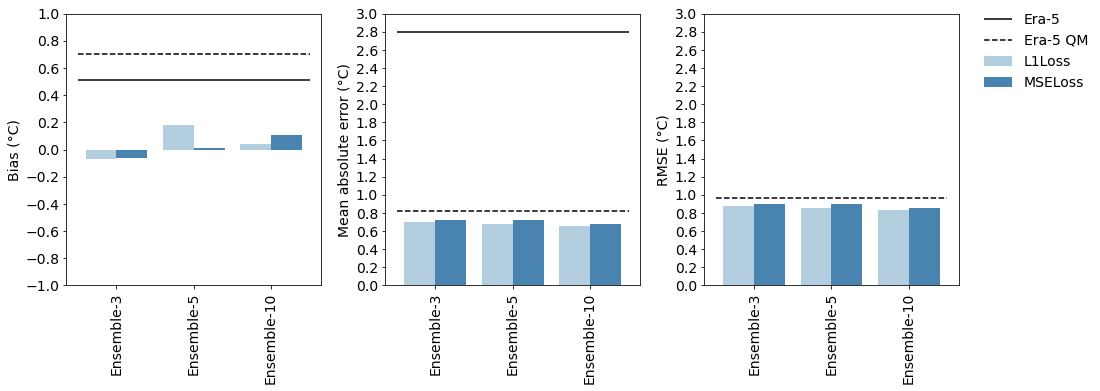

In [32]:
# initialize figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# plot bias: ensemble predictions vs. reference
sns.barplot(x='product', y='bias', hue='loss', data=ensemble, palette=palette, ax=axes[0]);

# plot mae: ensemble predictions vs. reference
sns.barplot(x='product', y='mae', hue='loss', data=ensemble, palette=palette, ax=axes[1]);

# plot rmse: ensemble predictions vs. reference
sns.barplot(x='product', y='rmse', hue='loss', data=ensemble, palette=palette, ax=axes[2]);

# add metrics for reference
for ax, metric in zip(axes, ['bias', 'mae', 'rmse']):
    for product, ls in zip(df_ref['product'], ['-', '--']):
        ax.hlines(df_ref[metric][df_ref['product'] == product].item(), xmin=-0.5, xmax=2.5,
                  color='k', ls=ls, label=product)

# axis for bias
axes[0].set_ylabel('Bias (%)' if PREDICTAND == 'pr' else 'Bias (°C)')
axes[0].set_ylim(y_lim_bias)
axes[0].set_yticks(y_ticks_bias)

# axis for mae
y_lim_mae = (0, 2) if PREDICTAND == 'pr' else (0, 3)
y_ticks_mae = np.arange(y_lim_mae[0], y_lim_mae[1] + 0.2, 0.2)
axes[1].set_ylabel('Mean absolute error (mm)' if PREDICTAND == 'pr' else 'Mean absolute error (°C)')
axes[1].set_ylim(y_lim_mae)
axes[1].set_yticks(y_ticks_mae)

# axis for rmse
axes[2].set_ylabel('RMSE (mm)' if PREDICTAND == 'pr' else 'RMSE (°C)')
axes[2].set_ylim(y_lim_mae)
axes[2].set_yticks(y_ticks_mae)

# axis fontsize and legend
for ax in axes:
    ax.tick_params('both', labelsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.yaxis.label.set_size(14)
    ax.set_xlabel('')
    
    # adjust legend
    h, _ = ax.get_legend_handles_labels()
    ax.get_legend().remove()

# show single legend
axes[-1].legend(bbox_to_anchor=(1.05, 1.05), loc=2, frameon=False, fontsize=14);

# save figure
fig.subplots_adjust(wspace=0.25)
fig.savefig('./Figures/bootstrap/{}_ensemble_vs_reference.pdf'.format(PREDICTAND), bbox_inches='tight')

### Time series

In [33]:
# calculate loss function with lowest overall error (bias, mae, and rmse)
ens = ensemble[ensemble['product'] == 'Ensemble-10'].copy()
ens['sum'] = np.abs(ens['bias']) + ens['rmse'] + ens['mae']
min_loss = ens[ens['sum'] == ens['sum'].min()]['loss'].item()

In [34]:
# whether to compute rolling or hard mean
ROLLING = True

In [35]:
# define scale of mean time series
# scale = '1M'  # monthly
scale = '1Y'  # yearly

In [36]:
# check if time series exists
ts_path = RESULTS.joinpath(PREDICTAND, '{}_ts_{}.nc'.format(PREDICTAND, scale if not ROLLING else 'rolling'))
if ts_path.exists():
    time_series = xr.open_dataset(ts_path).load()
else:
    # mean time series over entire grid and validation period
    if ROLLING:
        y_pred_ts = {k: v.rolling(time=365, center=True).mean().mean(dim=('y', 'x')).dropna('time').compute() for k, v in ensemble_mean_full.items()}
        y_pred_ts_var = {k: v.rolling(time=365, center=True).mean().mean(dim=('y', 'x')).dropna('time').compute()for k, v in ensemble_std_full.items()}
        y_true_ts = y_true.rolling(time=365, center=True).mean().mean(dim=('y', 'x')).dropna('time').compute()
        y_refe_ts = y_refe.rolling(time=365, center=True).mean().mean(dim=('y', 'x')).dropna('time').compute()
        y_refe_qm_ts = y_refe_qm.rolling(time=365, center=True).mean().mean(dim=('y', 'x')).dropna('time').compute()
    else:
        y_pred_ts = {k: v.resample(time=scale).mean(dim=('time', 'y', 'x')).compute() for k, v in ensemble_mean_full.items()}
        y_pred_ts_var = {k: v.resample(time=scale).mean(dim=('time', 'y', 'x')).compute() for k, v in ensemble_std_full.items()}
        y_true_ts = y_true.resample(time=scale).mean(dim=('time', 'y', 'x')).compute()
        y_refe_ts = y_refe.resample(time=scale).mean(dim=('time', 'y', 'x')).compute()
        y_refe_qm_ts = y_refe_qm.resample(time=scale).mean(dim=('time', 'y', 'x')).compute()
    
    # create dataset of aggregated time series
    time_series = xr.Dataset({'y_true': y_true_ts, 'y_refe': y_refe_ts, 'y_refe_qm': y_refe_qm_ts,
                              **{'{}_mean'.format(k): v for k, v in y_pred_ts.items()},
                              **{'{}_std'.format(k): v for k, v in y_pred_ts_var.items()}})

    # save to disk for faster plotting
    time_series.to_netcdf('./{}_ts_{}.nc'.format(PREDICTAND, scale if not ROLLING else 'rolling'), engine='h5netcdf')

In [37]:
# color palette
palette = sns.color_palette('viridis', 3)

In [38]:
# factor of standard deviation to plot as uncertainty around ensemble mean prediction
std_factor = 1

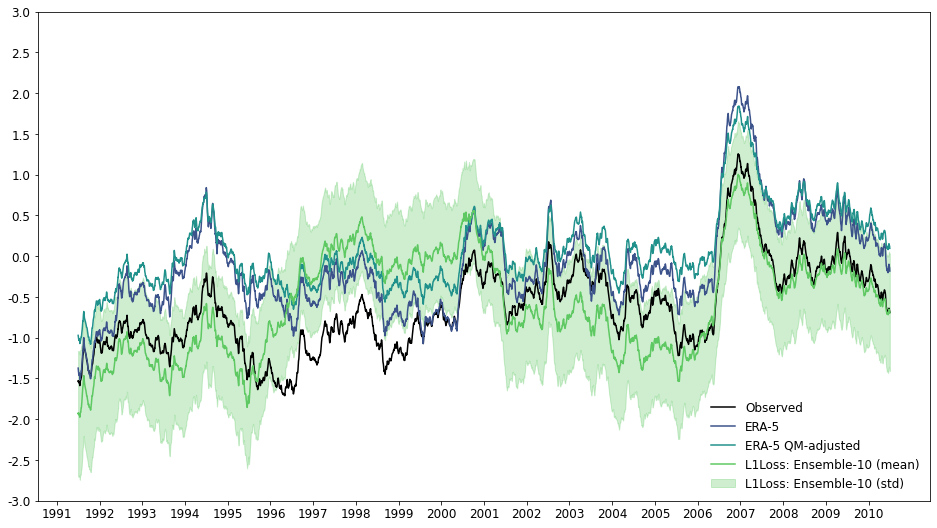

In [39]:
# initialize figure
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

# time to plot on x-axis
time = time_series.time.values if ROLLING else [t.astype('datetime64[{}]'.format(scale.lstrip('1'))) for t in time_series.time.values] 
xticks = [t.astype('datetime64[Y]') for t in list(time_series.time.resample(time='1Y').groups.keys())]

# plot reference: observations, ERA-5, ERA-5 QM-adjusted
ax.plot(time, time_series.y_true, label='Observed', ls='-', color='k');
ax.plot(time, time_series.y_refe, label='ERA-5', ls='-', color=palette[0]);
ax.plot(time, time_series.y_refe_qm, label='ERA-5 QM-adjusted', ls='-', color=palette[1]);

# plot model predictions: ensemble mean and standard deviation
ax.plot(time, time_series['{}_mean'.format(min_loss)], label='{}: Ensemble-{:d} (mean)'.format(min_loss, len(models[min_loss])), color=palette[-1])
ax.fill_between(x=time, y1=time_series['{}_mean'.format(min_loss)].values - std_factor * time_series['{}_std'.format(min_loss)].values,
                y2=time_series['{}_mean'.format(min_loss)].values + std_factor * time_series['{}_std'.format(min_loss)].values,
                alpha=0.3, label='{}: Ensemble-{} (std)'.format(min_loss, len(models[min_loss])), color=palette[-1]);

# add legend
ax.legend(frameon=False, loc='lower right', fontsize=12)

# axis limits and ticks
if PREDICTAND == 'tasmin':
    yticks = np.arange(-3, 3.5, 0.5)
elif PREDICTAND == 'tasmax':
    yticks = np.arange(6, 12.5, 0.5)
else:
    yticks = np.arange(0, 5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.tick_params(axis='both', labelsize=12)

# save figure
fig.savefig('./Figures/bootstrap/{}_time_series_{}.pdf'.format(PREDICTAND, scale if not ROLLING else 'rolling'), bbox_inches='tight')

### Spatial distribution

In [40]:
# compute ensemble mean yearly mean bias of each grid point
pred = (((ensemble_mean_full[min_loss].groupby('time.year').mean(dim='time') - y_true_yearly_avg) / y_true_yearly_avg) * 100
        if PREDICTAND == 'pr' else (ensemble_mean_full[min_loss].groupby('time.year').mean(dim='time') - y_true_yearly_avg))
pred = pred.mean(dim='year').compute()

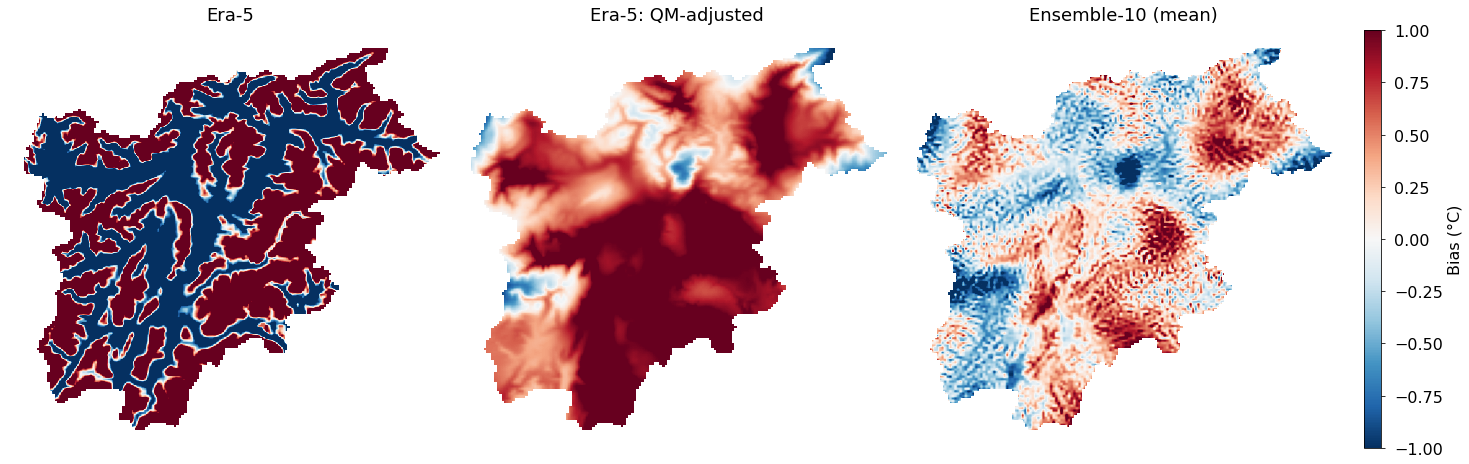

In [41]:
# plot yearly average bias of references and predictions
vmin, vmax = (-40, 40) if PREDICTAND == 'pr' else (-1, 1)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

# plot bias of ERA-5 reference
era5 = bias_refe.mean(dim='year')
im1 = axes[0].imshow(era5.values, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)

# plot bias of ERA-5 QM-adjusted reference
era5_qm = bias_refe_qm.mean(dim='year')
im2 = axes[1].imshow(era5_qm.values, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)

# plot bias of ensemble model prediction
im3 = axes[2].imshow(pred, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)

# set titles
axes[0].set_title('Era-5', fontsize=18, pad=10);
axes[1].set_title('Era-5: QM-adjusted', fontsize=18, pad=10);
axes[2].set_title('Ensemble-{:d} (mean)'.format(len(models[min_loss])), fontsize=18, pad=10)

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_axis_off()

# adjust figure
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im3, cax=cbar_ax_bias)
cbar_bias.set_label(label='Bias (%)' if PREDICTAND == 'pr' else 'Bias (°C)', fontsize=16)
cbar_bias.ax.tick_params(labelsize=16, pad=10)

# save figure
fig.savefig('./Figures/bootstrap/{}_spatial_bias.pdf'.format(PREDICTAND), bbox_inches='tight')